In [15]:
import numpy as np
import open3d as o3d  # type: ignore
import matplotlib.pyplot as plt
import torch

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    get_integer_segments,
    triangulate_segments,
)

In [16]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [17]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [18]:
mesh = o3d.io.read_triangle_mesh("../data/power-drill/textured.obj", enable_post_processing=True)

bake_uv_to_vertex_colours(mesh)

mesh.compute_vertex_normals()

bb = mesh.get_minimal_oriented_bounding_box()
scale = np.mean(bb.get_max_bound())

In [ ]:
###########################################################
# Colour helpers                                          #
###########################################################

def _interpolate_vertex_colors(mesh: o3d.geometry.TriangleMesh,
                               primitive_ids: np.ndarray,
                               bary_uv: np.ndarray) -> np.ndarray:
    """Interpolate per‑vertex colours of *mesh* at the hit points."""
    vcols = np.asarray(mesh.vertex_colors)
    tris = np.asarray(mesh.triangles, dtype=np.int32)

    tri = tris[primitive_ids]
    c0, c1, c2 = vcols[tri[:, :, 0]], vcols[tri[:, :, 1]], vcols[tri[:, :, 2]]

    u, v = bary_uv[:, :, 0], bary_uv[:, :, 1]
    w = 1.0 - u - v
    vcols = w[:, :, None] * c0 + u[:, :, None] * c1 + v[:, :, None] * c2

    return vcols

In [ ]:
###########################################################
# Main entry point                                        #
###########################################################

mesh: o3d.geometry.TriangleMesh
cam_centre=polar2cartesian(r=0.3, lat=90, long=150)
look_at=(0.0, 0.0, 0.0)
dropout_rate: float = 0
depth_error_std: float = 0.0
translation_error_std: float = 0.0
rotation_error_std_degs: float = 0.0
width_px: int = 360
height_px: int = 240
fov: float = 70.0
dist_thresh: float = 10.0

In [ ]:
###############
# Ray casting #
###############
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov,
    center=list(look_at),
    eye=list(cam_centre),
    up=[0, 0, 1],
    width_px=width_px,
    height_px=height_px,
)

ans = scene.cast_rays(rays)
t_hit = ans["t_hit"].numpy()

# Intersection metadata (triangle id + barycentric uv)
prim_ids = ans["primitive_ids"].numpy().astype(np.int32)
bary_uv = ans.get("primitive_uvs", None).numpy()

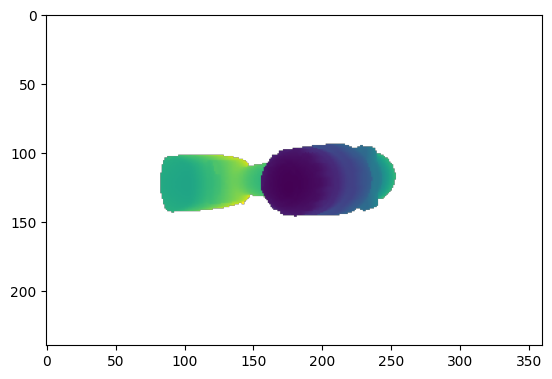

In [22]:
plt.imshow(t_hit)

In [23]:
########################
# Generate 3‑D vertices#
########################
rays_np = rays.numpy()  # (H*W,6)
origins = rays_np[..., :3]
dirs = rays_np[..., 3:]
noise = (depth_error_std * np.random.randn(*t_hit.shape)).astype(np.float32)
t_noisy = t_hit + noise
verts = origins + dirs * t_noisy[..., None]
verts = verts.reshape(-1, 3)
valid = np.isfinite(verts).all(axis=1)

In [24]:
######################################
# Optional colour interpolation step #
######################################
vcols: np.ndarray | None = None
if mesh.has_vertex_colors():
    if bary_uv is not None:
        vcols = _interpolate_vertex_colors(mesh, prim_ids, bary_uv)
    else:  # fall back to the first vertex of the hit triangle
        source_cols = np.asarray(mesh.vertex_colors)
        tri_first = np.asarray(mesh.triangles, dtype=np.int32)[prim_ids, 0]
        vcols = source_cols[tri_first]
    # invalid hits – set to black
    assert vcols is not None  # narrow type for mypy
    vcols.reshape(-1,3)[~valid] = np.full(3, 0.0)

In [25]:
masks = mask_generator.generate(vcols.astype(np.float32))

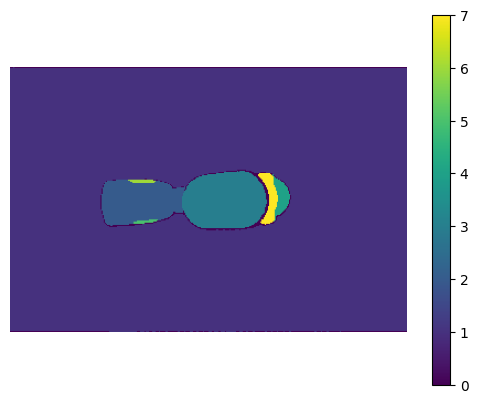

In [26]:
sp_regions = np.array([mask['segmentation'] for mask in masks])

int_seg = get_integer_segments(sp_regions)

plt.axis('off')
plt.imshow(int_seg)
plt.colorbar()

In [27]:
########################
# Re‑construct surface #
########################
tris = triangulate_segments(verts, int_seg)
all_tris = [tri for trise in tris for tri in trise]

mesh_out = o3d.geometry.TriangleMesh()
mesh_out.vertices = o3d.utility.Vector3dVector(verts)
mesh_out.triangles = o3d.utility.Vector3iVector(all_tris)

if vcols is not None:
    mesh_out.vertex_colors = o3d.utility.Vector3dVector(vcols.reshape(-1,3))

In [28]:
#############################
# Clean‑up / post‑processing#
#############################
mesh_out.remove_unreferenced_vertices()
mesh_out.remove_degenerate_triangles()
mesh_out.remove_duplicated_triangles()
mesh_out.remove_non_manifold_edges()
mesh_out.compute_vertex_normals()

TriangleMesh with 6652 points and 12556 triangles.

In [29]:
######################
# Registration error #
######################
mesh_out.translate(tuple(np.random.randn(3) * translation_error_std))
R = mesh.get_rotation_matrix_from_xyz(
    tuple(np.random.randn(3) * np.deg2rad(rotation_error_std_degs))
)
mesh_out.rotate(R, center=mesh_out.get_center())

TriangleMesh with 6652 points and 12556 triangles.

In [30]:
#######################
# Noised point cloud  #
#######################
pcd = o3d.t.geometry.PointCloud(o3d.core.Tensor(verts, dtype=o3d.core.Dtype.Float32))
pcd = pcd.translate(tuple(np.random.randn(3) * translation_error_std))
R = mesh.get_rotation_matrix_from_xyz(
    tuple(np.random.randn(3) * np.deg2rad(rotation_error_std_degs))
)
pcd = pcd.rotate(R, center=pcd.get_center())

In [31]:
o3d.visualization.draw_geometries([mesh_out])